In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Read all data files

In [2]:
base_path = os.path.abspath("../data_directory/unclean_data")

# Read the data
df_accounts = pd.read_csv(os.path.join(base_path, "accounts.csv"))
df_dictData = pd.read_csv(os.path.join(base_path, "data_dictionary.csv"))
df_products = pd.read_csv(os.path.join(base_path, "products.csv"))
df_pipeline = pd.read_csv(os.path.join(base_path, "sales_pipeline.csv"))
df_teams = pd.read_csv(os.path.join(base_path, "sales_teams.csv"))

In [3]:
datasets = {
    "Accounts" : df_accounts,
    "DictData" : df_dictData,
    "Products" : df_products,
    "Pipeline" : df_pipeline,
    "Teams" : df_teams
}

# Exploring the datasets

## accounts.csv

This dataset shows which accounts are open, the sectors or fields they’re in, the year they were established for historical context, their revenue and number of employees, their office locations, and whether they’re subsidiaries of another company.

In [4]:
df_accounts.head()

,account,sector,year_established,revenue,employees,office_location,subsidiary_of
0,Acme Corporation,technolgy,1996,1100.04,2822,United States,NaN
1,Betasoloin,medical,1999,251.41,495,United States,NaN
2,Betatech,medical,1986,647.18,1185,Kenya,NaN
3,Bioholding,medical,2012,587.34,1356,Philipines,NaN
4,Bioplex,medical,1991,326.82,1016,United States,NaN


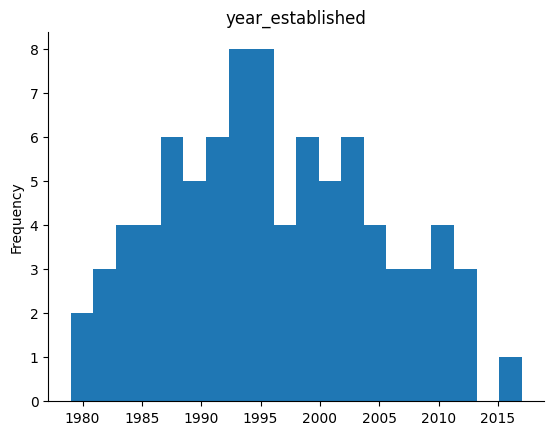

In [5]:
# @title year_established

df_accounts['year_established'].plot(kind='hist', bins=20, title='year_established')
plt.gca().spines[['top', 'right',]].set_visible(False)

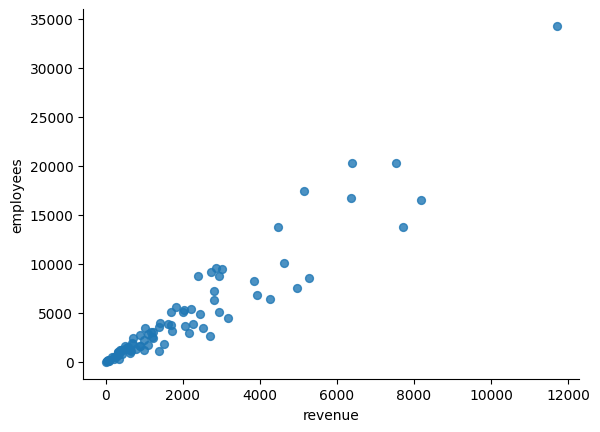

In [6]:
# @title revenue vs employees

df_accounts.plot(kind='scatter', x='revenue', y='employees', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## data_dictionary.csv

This dataset explains what all of the fields (column names) in all of the other datasets mean.

In [7]:
df_dictData.head()

,Table,Field,Description
0,accounts,account,Company name
1,accounts,sector,Industry
2,accounts,year_established,Year Established
3,accounts,revenue,Annual revenue (in millions of USD)
4,accounts,employees,Number of employees


## products.csv

This dataset shows products and sales prices for 7 products that the sales team most likely tracks.

In [8]:
df_products.head()

,product,series,sales_price
0,GTX Basic,GTX,550
1,GTX Pro,GTX,4821
2,MG Special,MG,55
3,MG Advanced,MG,3393
4,GTX Plus Pro,GTX,5482


## sales_pipeline.csv

This dataset links sales agents to the products in `products.csv`, showing which deals were active, when they started, when they closed, the value at closing, and the account involved.

In [9]:
df_pipeline.head()

,opportunity_id,sales_agent,product,account,deal_stage,engage_date,close_date,close_value
0,1C1I7A6R,Moses Frase,GTX Plus Basic,Cancity,Won,2016-10-20,2017-03-01,1054.0
1,Z063OYW0,Darcel Schlecht,GTXPro,Isdom,Won,2016-10-25,2017-03-11,4514.0
2,EC4QE1BX,Darcel Schlecht,MG Special,Cancity,Won,2016-10-25,2017-03-07,50.0
3,MV1LWRNH,Moses Frase,GTX Basic,Codehow,Won,2016-10-25,2017-03-09,588.0
4,PE84CX4O,Zane Levy,GTX Basic,Hatfan,Won,2016-10-25,2017-03-02,517.0


## sales_teams.csv

In [10]:
df_teams.head()

,sales_agent,manager,regional_office
0,Anna Snelling,Dustin Brinkmann,Central
1,Cecily Lampkin,Dustin Brinkmann,Central
2,Versie Hillebrand,Dustin Brinkmann,Central
3,Lajuana Vencill,Dustin Brinkmann,Central
4,Moses Frase,Dustin Brinkmann,Central


The code below performs median imputation which is the process of replacing each missing value with a numerical value that is the meadian of all the non-missing values; it also drops all duplicate values.

**Note**: When I use dataDict_List I refer to a list of dictionaries for our dataframes, every functionality changed in the dataset has its corresponding functions

# Standardize all column names

In [11]:
def standardizeColumnNames(dataDict_List):
    for names, df in dataDict_List.items():
        print(f"standardizing columns {names}")
        for col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].str.strip().str.lower().str.replace(' ','_')
        print(f"Completed standardizing columns for {names}")

Fix some typos in the accounts data set:

In [12]:
if "sector" in df_accounts.columns:
    df_accounts["sector"] = df_accounts["sector"].replace({"technolgy": "technology"})
if "office_location" in df_accounts.columns:
    df_accounts["office_location"] = df_accounts["office_location"].replace({"Philipines": "Philippines"})


In [13]:
def dataset_analysis(dataDict_List):
    for name, df in dataDict_List.items():
        print(f"Missing Values for {name}")
        missingValues = df.isnull().sum()
        missingValues = missingValues.sort_values(ascending=False)

        print(missingValues)

In [14]:
dataset_analysis(datasets)

Missing Values for Accounts
subsidiary_of       70
account              0
sector               0
year_established     0
revenue              0
employees            0
office_location      0
dtype: int64
Missing Values for DictData
Table          0
Field          0
Description    0
dtype: int64
Missing Values for Products
product        0
series         0
sales_price    0
dtype: int64
Missing Values for Pipeline
close_date        2089
close_value       2089
account           1425
engage_date        500
opportunity_id       0
sales_agent          0
product              0
deal_stage           0
dtype: int64
Missing Values for Teams
sales_agent        0
manager            0
regional_office    0
dtype: int64


# Clean datasets

In [15]:
def clean_datasets(dataDict_List):
    print("Cleaning Datasets")
    for df in dataDict_List.values():
        # Remove duplicates
        df.drop_duplicates(inplace=True)

        # Handle missing values for numeric columns
        for col in df.columns:
            if df[col].dtype in ["int64", "float64", "number"]:
                median_values = df[col].median()
                df[col] = df[col].fillna(median_values)
            else:
                mode = df[col].mode()[0]
                df[col] = df[col].fillna(mode)

        # Handle missing values for categorical columns (Yuupar's implementation)
        for col in df.select_dtypes(include=['object']):
            if df[col].isna().any() and "date" not in col.lower(): # Excluding date columns to not fill them with random dates
                df[col] = df[col].fillna(df[col].mode()[0]) #  Fill with most frequent value

    print("Completed dataset cleaning")


## Standardize dates

Converts text to proper date format (YYYY-MM-DD).

*"coerce" means if you can't convert something to a date, turn it into NaT (Not a Time)*

In [16]:
def standardize_dates(dataDict_List):
    # Standardize date
    for df in dataDict_List.values():
        for col in df.columns:
            if "date" in col.lower():
                df[col] = pd.to_datetime(df[col], errors="coerce")
                print("Completed standardizing dates)")

## Handle missing dates

Drops rows with missing dates to only keep dates of deals with a valid record. If we don't know when a deal started, we can't analyze it properly and a deal that "started" on a fake date will give wrong sales cycle calculations.

In [17]:
def handle_missing_dates(dataDict_List):
    if 'Pipeline' in dataDict_List:
        df_pipeline = dataDict_List['Pipeline']
        original_rows = len(df_pipeline)

        # Drop rows with missing engage_date or close_date for won deals
        df_pipeline.dropna(subset=['engage_date'], inplace=True)

        # For won deals, close_date should not be missing
        won_deals = df_pipeline['deal_stage'] == 'won'
        df_pipeline = df_pipeline[~(won_deals & df_pipeline['close_date'].isna())]

        dataDict_List['Pipeline'] = df_pipeline
        print(f"Removed {original_rows - len(df_pipeline)} rows with missing critical dates")

    print("Completed handling missing dates")

## Standardize currencies

In [18]:
def currency_standard(dataDict_List):
  for df in dataDict_List.values():
    for col in df.columns:
      moneyColumns = [c for c in df.columns if "amount" in c or "revenue" in c]
      for col in moneyColumns:
        df[col] = df[col].astype(float)
        print("Completed standardizing currency")

## Convert all numbers to floats

In [19]:
def convert_numbers_to_float(dataDict_List):
    for name, df in dataDict_List.items():
        for col in df.columns:
            if df[col].dtype in ['int64', 'int32', 'float32', 'number']:
                df[col] = df[col].astype('float64')
        print(f"Completed numeric conversion for {name}")

In [20]:
dataset_analysis(datasets)

Missing Values for Accounts
subsidiary_of       70
account              0
sector               0
year_established     0
revenue              0
employees            0
office_location      0
dtype: int64
Missing Values for DictData
Table          0
Field          0
Description    0
dtype: int64
Missing Values for Products
product        0
series         0
sales_price    0
dtype: int64
Missing Values for Pipeline
close_date        2089
close_value       2089
account           1425
engage_date        500
opportunity_id       0
sales_agent          0
product              0
deal_stage           0
dtype: int64
Missing Values for Teams
sales_agent        0
manager            0
regional_office    0
dtype: int64


## Applying all feature engineering to datasets

In [21]:
standardizeColumnNames(datasets)
clean_datasets(datasets)
standardize_dates(datasets)
handle_missing_dates(datasets)
currency_standard(datasets)
convert_numbers_to_float(datasets)

standardizing columns Accounts
Completed standardizing columns for Accounts
standardizing columns DictData
Completed standardizing columns for DictData
standardizing columns Products
Completed standardizing columns for Products
standardizing columns Pipeline
Completed standardizing columns for Pipeline
standardizing columns Teams
Completed standardizing columns for Teams
Cleaning Datasets
Completed dataset cleaning
Completed standardizing dates)
Completed standardizing dates)
Removed 0 rows with missing critical dates
Completed handling missing dates
Completed standardizing currency
Completed standardizing currency
Completed standardizing currency
Completed standardizing currency
Completed standardizing currency
Completed standardizing currency
Completed standardizing currency
Completed numeric conversion for Accounts
Completed numeric conversion for DictData
Completed numeric conversion for Products
Completed numeric conversion for Pipeline
Completed numeric conversion for Teams


## Viewing the information from all datasets

In [22]:
def analysisDataSets(dataDict_List):
    for name, df in dataDict_List.items():
        print(f"Information of {name}:")
        df.info()
analysisDataSets(datasets)

Information of Accounts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   account           85 non-null     object 
 1   sector            85 non-null     object 
 2   year_established  85 non-null     float64
 3   revenue           85 non-null     float64
 4   employees         85 non-null     float64
 5   office_location   85 non-null     object 
 6   subsidiary_of     85 non-null     object 
dtypes: float64(3), object(4)
memory usage: 4.8+ KB
Information of DictData:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Table        21 non-null     object
 1   Field        21 non-null     object
 2   Description  21 non-null     object
dtypes: object(3)
memory usage: 632.0+ bytes
Information of Produc

# Data cleaning verification

Checking for duplicates in the data:

In [23]:
for name, df in datasets.items():
    print(f"{name} duplicates: {df.duplicated().sum()}")

Accounts duplicates: 0
DictData duplicates: 0
Products duplicates: 0
Pipeline duplicates: 0
Teams duplicates: 0


Printing column names to validate the standardization:

In [24]:
for name, df in datasets.items():
  print(f"\n{name.upper()}")
  print(df.columns)


ACCOUNTS
Index(['account', 'sector', 'year_established', 'revenue', 'employees',
       'office_location', 'subsidiary_of'],
      dtype='object')

DICTDATA
Index(['Table', 'Field', 'Description'], dtype='object')

PRODUCTS
Index(['product', 'series', 'sales_price'], dtype='object')

PIPELINE
Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_date', 'close_date', 'close_value'],
      dtype='object')

TEAMS
Index(['sales_agent', 'manager', 'regional_office'], dtype='object')


Checking for missing values:

In [25]:
for name, df in datasets.items():
    print(f"\n{name.upper()}")
    print(df.isnull().sum())


ACCOUNTS
account             0
sector              0
year_established    0
revenue             0
employees           0
office_location     0
subsidiary_of       0
dtype: int64

DICTDATA
Table          0
Field          0
Description    0
dtype: int64

PRODUCTS
product        0
series         0
sales_price    0
dtype: int64

PIPELINE
opportunity_id    0
sales_agent       0
product           0
account           0
deal_stage        0
engage_date       0
close_date        0
close_value       0
dtype: int64

TEAMS
sales_agent        0
manager            0
regional_office    0
dtype: int64


Checking the data types:

In [26]:
for name, df in datasets.items():
    print(f"\n{name.upper()} DATA TYPES:")
    print(df.dtypes)


ACCOUNTS DATA TYPES:
account              object
sector               object
year_established    float64
revenue             float64
employees           float64
office_location      object
subsidiary_of        object
dtype: object

DICTDATA DATA TYPES:
Table          object
Field          object
Description    object
dtype: object

PRODUCTS DATA TYPES:
product         object
series          object
sales_price    float64
dtype: object

PIPELINE DATA TYPES:
opportunity_id            object
sales_agent               object
product                   object
account                   object
deal_stage                object
engage_date       datetime64[ns]
close_date        datetime64[ns]
close_value              float64
dtype: object

TEAMS DATA TYPES:
sales_agent        object
manager            object
regional_office    object
dtype: object


Checking categorical values (first 10 unique values):

In [27]:
for name, df in datasets.items():
    print(f"\n{name.upper()} CATEGORICAL VALUES:")
    for col in df.select_dtypes(include="object").columns:
        print(f"{col}: {df[col].unique()[:10]}")


ACCOUNTS CATEGORICAL VALUES:
account: ['acme_corporation' 'betasoloin' 'betatech' 'bioholding' 'bioplex'
 'blackzim' 'bluth_company' 'bubba_gump' 'cancity' 'cheers']
sector: ['technology' 'medical' 'retail' 'software' 'entertainment' 'marketing'
 'telecommunications' 'finance' 'employment' 'services']
office_location: ['united_states' 'kenya' 'philippines' 'japan' 'italy' 'norway' 'korea'
 'jordan' 'brazil' 'germany']
subsidiary_of: ['acme_corporation' 'massive_dynamic' 'bubba_gump' 'inity' 'sonron'
 'golddex' 'warephase']

DICTDATA CATEGORICAL VALUES:
Table: ['accounts' 'products' 'sales_teams' 'sales_pipeline']
Field: ['account' 'sector' 'year_established' 'revenue' 'employees'
 'office_location' 'subsidiary_of' 'product' 'series' 'sales_price']
Description: ['company_name' 'industry' 'year_established'
 'annual_revenue_(in_millions_of_usd)' 'number_of_employees'
 'headquarters' 'parent_company' 'product_name' 'product_series'
 'suggested_retail_price']

PRODUCTS CATEGORICAL VALUES:

Checking numeric ranges and statistics:

In [28]:
for name, df in datasets.items():
    print(f"\n{name.upper()} NUMERIC SUMMARY:")
    numeric_cols = df.select_dtypes(include=['number', 'int64', 'float64']).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe())
    else:
        print("No numeric columns found")


ACCOUNTS NUMERIC SUMMARY:
       year_established       revenue     employees
count         85.000000     85.000000     85.000000
mean        1996.105882   1994.632941   4660.823529
std            8.865427   2169.491436   5715.601198
min         1979.000000      4.540000      9.000000
25%         1989.000000    497.110000   1179.000000
50%         1996.000000   1223.720000   2769.000000
75%         2002.000000   2741.370000   5595.000000
max         2017.000000  11698.030000  34288.000000

DICTDATA NUMERIC SUMMARY:
No numeric columns found

PRODUCTS NUMERIC SUMMARY:
        sales_price
count      7.000000
mean    6023.571429
std     9388.428070
min       55.000000
25%      823.000000
50%     3393.000000
75%     5151.500000
max    26768.000000

PIPELINE NUMERIC SUMMARY:
        close_value
count   8800.000000
mean    1249.038864
std     2072.411434
min        0.000000
25%        0.000000
50%      472.000000
75%     1085.250000
max    30288.000000

TEAMS NUMERIC SUMMARY:
No numeric colu

## Saving the cleaned datasets into `clean_data` folder

In [29]:
def save_csv(dataDict_List):
    base_dir = "data_directory"
    clean_dir = os.path.join(base_dir, "clean_data")
    
    # Only create the clean_data folder if it doesn't already exist
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
        
    for name, df in dataDict_List.items():
        try:
            df.to_csv(os.path.join(clean_dir, f"{name}.csv"), index=False)
        except Exception as e:
            print(f"Failed to save {name}: {e}")

In [30]:
save_csv(datasets)